<a href="https://colab.research.google.com/github/FidelNavarro/PHYS5020/blob/main/Radiomics_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Exams Project: Radiomics

PHYS5020

Code by Fidel Alejandro Navarro Salazar (520176832)


This code applies a de-noising to T2-weighted MRI images through an AutoEncoder.


The data provided consists of 174 T2-weighted MRI 3D images for prostate. The images have an in-plane resolution of 384 x 384 

Folder structure:
* train-x : training data for the inputs (images with noise)
* train-y : training data for the labels (images without noises)
* test-x : input data to be applied to the trained model. To be compared to the fround truth.


In [1]:
#@title Download and Unzip Folder
#We start by downloading the data folder
#!gdown 1i4z0ALISk05y2f219f22inYC9zmKJX8M
!gdown 1VEE2BKHC4YMp850QA5dSgadlo3kblBp_

#https://drive.google.com/file/d/1VEE2BKHC4YMp850QA5dSgadlo3kblBp_/view?usp=sharing

#UnZip folder
import zipfile
with zipfile.ZipFile('/content/5020-dae-data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

Downloading...
From: https://drive.google.com/uc?id=1VEE2BKHC4YMp850QA5dSgadlo3kblBp_
To: /content/5020-dae-data.zip
100% 1.90G/1.90G [00:19<00:00, 98.8MB/s]


In [2]:
#@title Definition of General Functions
#Data is in NIfTI format, so nibabel will be used to read the files
import nibabel as nb
import os
import numpy as np 
from skimage.transform import resize #function will be use to reshape image
from math import ceil

#Packages used to define the model
import tensorflow as tf
import keras
from keras import layers

#Create an array with the name of files inside the folder
def ReadFolder(path): #'path' defines the location of the folder
    folder = os.listdir(path)
  #Blank list 
    data = []
  #Loop to save 3D images in list
    for i in folder:
    #image is read
        img = nb.load(path + i).get_fdata()
    #reshape to 384x384 in plane
        img = resize(img, (384,384) )
        img = (img - img.min() )/( img.max() - img.min() ) #Normalization
    #load each slice individualy to the list
        for j in range(img.shape[2]):
            data.append(img[:,:,j])
    #adjust data so it can work properly on network
    data = np.array(data)#, dtype='float32') #float 64 crashed the CPU on regular Colab
    data = np.reshape(data, (data.shape[0], 384, 384, 1) ) #data structure should be (#slices, 384, 384, #channels=1)
    data = np.transpose(data, (0,2,1,3)) #during appending of images the x and y axis gets flipped
    return data

#Visualization of data
import matplotlib.pyplot as plt
def plotIMG(x, y, slice=1):
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(20,10)

    ax[0].imshow(x[slice], cmap='gray')
    ax[0].set_title('Noisy Image (Slice '+str(slice+1) + ')' )
    ax[0].axis('off')

    ax[1].imshow(y[slice], cmap='gray')
    ax[1].set_title('Denoised Image (Slice '+str(slice+1) + ')')
    ax[1].axis('off')
    plt.show()

#Function for visualization of Loss graph
def plotPerf(model):
    #epochs = np.linspace(1,epochs,epochs)
    #acc = model.history['accuracy']
    #val_acc = model.history['val_accuracy']
    loss = model.history['loss']
    val_loss = model.history['val_loss']

    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(8,5)
    
    ax.plot(loss, label='Training')
    ax.plot(val_loss, label='Validation')
    ax.set_title("Training and Validation Loss", size=20)
    ax.set_xlabel("Epochs", size=20)
    ax.set_ylabel('Loss', size=20)
    ax.legend()
    
    plt.show()

#Function for fitting the model to the testing data and saving the new "Denoised" images in a folder
def ModApp(autoencoder, SaveFolder):
    for i in os.listdir('test-x/'): #The function loops through each scan
        nft = nb.load('test-x/'+ i)
        scan = nft.get_fdata()
        #print(scan.shape)
        scan = resize(scan, (384,384) )
        #scan = zoom(scan, (384/scan.shape[0], 384/scan.shape[1], 1)) #Reshape 384x384
        scan = ( scan - scan.min() )/ ( scan.max() - scan.min() ) #Normalize
        scan = np.transpose(scan, (2,1,0)) 
        DeNoisedScan = autoencoder.predict(scan)
          #print(DeNoisedScan[:,:,:,0].shape)
        #DeNoisedScan = DeNoisedScan/DeNoisedScan.max()
        #print(DeNoisedScan.shape)
        DeNoisedScan = ( DeNoisedScan - DeNoisedScan.min() )/ ( DeNoisedScan.max() - DeNoisedScan.min() ) #Normalize
        DeNoisedScan = np.transpose(DeNoisedScan[:,:,:,0])
        final_img = nb.Nifti1Image(DeNoisedScan, nft.affine, nft.header)
        nb.save(final_img, os.path.join(SaveFolder, 'Denoised_'+ i))
    return scan, DeNoisedScan

# Read Folders "train-x" and "train-y"

In [3]:
#Read data from folders and save it into an array
#test_x = ReadFolder('/content/test-x/') #test_x folder will be read at the end to save RAM
train_x = ReadFolder('/content/train-x/')
train_y = ReadFolder('/content/train-y/')

In [4]:
#@title Visualization of Data

#Lets look at the size of the data
print('train_x =', train_x.shape)
print('train_y =', train_y.shape)

train_x = (3561, 384, 384, 1)
train_y = (3561, 384, 384, 1)


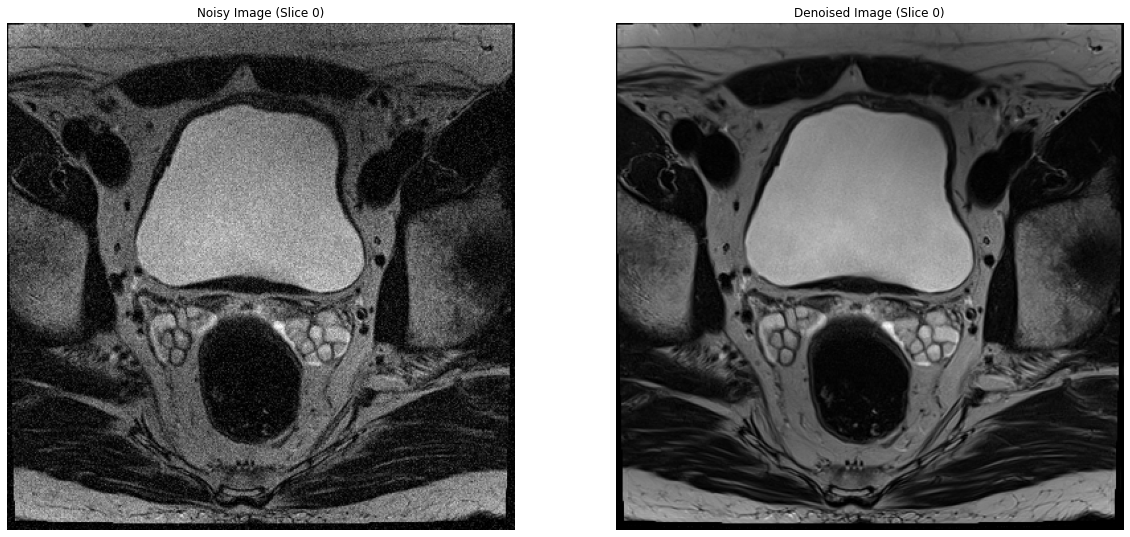

In [9]:
#@title Plot Data
plotIMG(train_x[:,:,:,0], train_y[:,:,:,0], -1)
#plotIMG(test_x, test_x)

# Data Partitioning and Preprocessing

In [10]:
#@title Partition data
#model will be train with 70% of the data
from sklearn.model_selection import train_test_split
trData, tsData, trLabel, tsLabel = train_test_split(
                                      train_x, train_y, 
                                      random_state=42, test_size=0.3)

print('trData =', trData.shape, 'trLabel =', trLabel.shape)
print('tsData =', tsData.shape, 'tsLabel =', tsLabel.shape)

trData = (2492, 384, 384, 1) trLabel = (2492, 384, 384, 1)
tsData = (1069, 384, 384, 1) tsLabel = (1069, 384, 384, 1)


In [27]:
#@title ImageDataGenerator
#Create a function to generated tensor image batches with real time data augmentation(rotation)
from keras.preprocessing.image import ImageDataGenerator
#General function for data augmentation (with a rotation range of 30 degrees)
datagen = ImageDataGenerator() #no data augmentation was used since it drastically affected output

valgen = ImageDataGenerator()
batchS = 64 #a higher batch size was not able to be used, batchS >= 128 fills the GPU memory

#generate the batches for traning data
train_iterator = datagen.flow(trData, trLabel, 
                              shuffle=True,
                              batch_size=batchS
                              )
#generate the batches for data validation
val_iterator = valgen.flow(tsData, tsLabel,
                           shuffle=True,
                           batch_size=batchS
                            )
#Note: the highest batch size achieved was of 64 for float32
#values greater than 64 filled the GPU memory, crashing the GPU

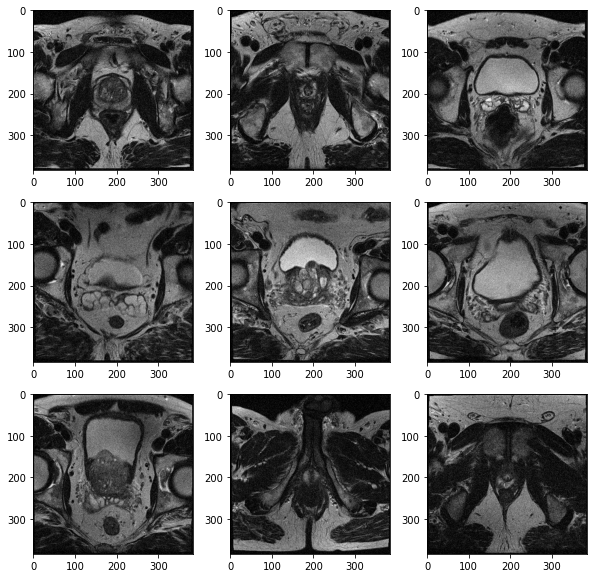

In [23]:
#@title Visualization of Augmented Data
it = datagen.flow(tsData, batch_size=1)
# generate samples and plot
fig, ax = plt.subplots(3,3)
fig.set_size_inches(10,10)
for i in range(3):
	# convert to unsigned integers for viewing
  #plt.figure.set_size_inches(20,10)
	# generate batch of images
  for j in range(3):
    batch = it.next()
    image = batch[0]
    ax[i][j].imshow(image.squeeze(), cmap='gray')
plt.show()

# MODEL 1:

Encoder:
* 2 convolutional layers
* 2 downsampling layers

Decoder:
* 2 deconvolutional layers
* 2 upsampling layers

In [35]:
#Define AutoEncoder 1

input_img = keras.Input(shape=(384,384,1)) #input layer stating image dimensions
#Encoder
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img) #use of 32 filters
x = layers.MaxPooling2D((2,2), padding='same')(x) #reduce spatial dimesions by 2 (384-->192)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x) #use of 64 filters

encoded = layers.MaxPooling2D((2,2), padding='same')(x) #reduce spatial dimensions by a factor of 2 (192-->96)
#Decoder
x = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same')(encoded) #use 64 filters
x = layers.UpSampling2D((2,2))(x) #increase spatial dimensions by factor of 2 (96-->192)
x = layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x) #use 32 filters
x = layers.UpSampling2D((2,2))(x) #increase spatial dimension by factor of 2 (192-->384)

decoded = layers.Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same')(x) 

#Model
autoencoder1 = keras.Model(input_img, decoded)
#autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
autoencoder1.compile(optimizer='adam', loss='mean_squared_error')

In [36]:
autoencoder1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 384, 384, 1)]     0         
                                                                 
 conv2d_11 (Conv2D)          (None, 384, 384, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 192, 192, 32)     0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 192, 192, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 96, 96, 64)       0         
 2D)                                                             
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 96, 96, 64)       3692

In [37]:
ep=50
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5) #stop the model training if no improvements after 5 epochs
model = autoencoder1.fit(train_iterator,
                        epochs=ep,
                        steps_per_epoch = ceil(trData.shape[0] / batchS), #2492 / 128 = 19.46 ~ 20
                        #batch_size=64, #batchS, #crashes with batch size 128
                        #the batch size isn't being provided given that the it was defined in the ImgGenerator 
                        validation_data=val_iterator,
                         callbacks=[callback])

Epoch 1/50
39/39 [==============================] - 6s 140ms/step - loss: 0.0378 - val_loss: 0.0088
Epoch 2/50
39/39 [==============================] - 5s 133ms/step - loss: 0.0076 - val_loss: 0.0058
Epoch 3/50
39/39 [==============================] - 5s 136ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 4/50
39/39 [==============================] - 5s 137ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 5/50
39/39 [==============================] - 5s 137ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 6/50
39/39 [==============================] - 5s 136ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 7/50
39/39 [==============================] - 5s 136ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 8/50
39/39 [==============================] - 5s 137ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 9/50
39/39 [==============================] - 5s 137ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 10/50
39/39 [==============================] - 5s 136ms/step - loss: 0.0026 - val_loss: 0.0026

In [38]:
autoencoder1.save('model_01_Denoised.h5')

In [14]:
from google.colab import files
files.download('model_01_Denoised.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

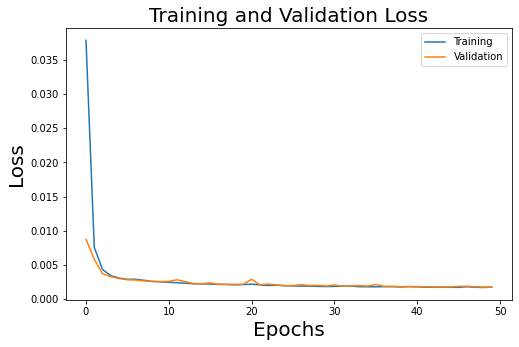

In [39]:
plotPerf(model) #plot accuracy and loss

In [40]:
foldPath = "M01_Denoised_test-x/"
if not os.path.exists(foldPath):
    os.makedirs(foldPath)
scan, DeNoisedScan = ModApp(autoencoder1, foldPath)

1/1 [==============================] - 0s 23ms/step


In [41]:
print(DeNoisedScan.T.shape)
print(scan.shape)

(21, 384, 384)
(21, 384, 384)


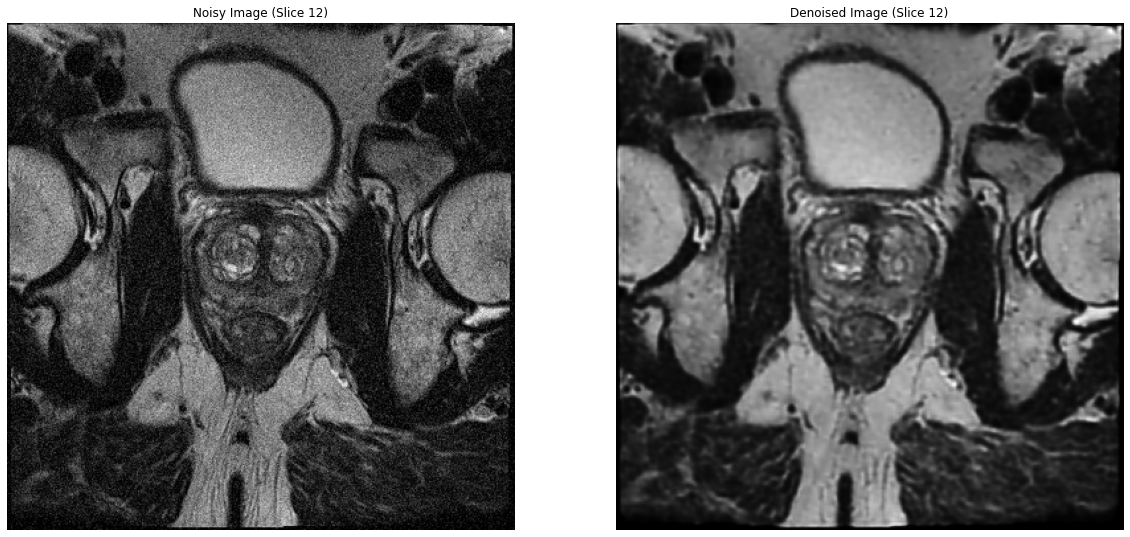

In [45]:
plotIMG(scan, DeNoisedScan.T, 11)

In [19]:
#!zip -r /content/M01_Denoised_test-x.zip /content/M01_Denoised_test-x
#files.download('/content/M01_Denoised_test-x.zip')

# MODEL 2:

Encoder:
* 2 convolutional layers
* 2 downsampling layers

Decoder:
* 2 deconvolutional layers
* 2 upsampling layers

Changes:
* Increase the number of filters in each layer, from 32 to 64 and 128
* Inner layers have bigger number of filters (128)
* Changed the size of the kernel for the outer layers

In [46]:
#Define AutoEncoder 2
import tensorflow as tf
import keras
from keras import layers

input_img = keras.Input(shape=(384,384,1)) #input layer stating image dimensions
#Encoder
x = layers.Conv2D(64, (5,5), activation='relu', padding='same')(input_img) #use of 64 filters
x = layers.MaxPooling2D((2,2), padding='same')(x) #reduce spatial dimesions by 2 (384-->192)
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x) #use of 64 filters


encoded = layers.MaxPooling2D((2,2), padding='same')(x) #reduce spatial dimensions by a factor of 2 (96-->38)
#Decoder
x = layers.Conv2DTranspose(128, (3,3), activation='relu', padding='same')(encoded) #use 64 filters
x = layers.UpSampling2D((2,2))(x) #increase spatial dimensions by factor of 2 (38-->96)
x = layers.Conv2DTranspose(68, (5,5), activation='relu', padding='same')(x) #use 128 filters
x = layers.UpSampling2D((2,2))(x) #increase spatial dimension by factor of 2 (96-->192)


decoded = layers.Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same')(x) 

#RMSE function
def ssim_loss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

#Model
autoencoder2 = keras.Model(input_img, decoded)
#autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
autoencoder2.compile(optimizer='adam', loss='mean_squared_error')

In [47]:
autoencoder2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 384, 384, 1)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 384, 384, 64)      1664      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 192, 192, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 192, 192, 128)     73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 96, 96, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 96, 96, 128)      1475

In [48]:
ep=50
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
model = autoencoder2.fit(train_iterator,
                        steps_per_epoch = ceil(trData.shape[0] / batchS), #2492 / 128 = 19.4
                        epochs=ep,
                        #batch_size=64, 
                        #a batch size greater than 64 crashed the system, reached the limit of available RAM
                        shuffle=True,
                        validation_data=val_iterator,
                        callbacks=[callback])

Epoch 1/50
39/39 [==============================] - 15s 322ms/step - loss: 0.0253 - val_loss: 0.0070
Epoch 2/50
39/39 [==============================] - 9s 238ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 3/50
39/39 [==============================] - 9s 239ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 4/50
39/39 [==============================] - 9s 239ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 5/50
39/39 [==============================] - 9s 240ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 6/50
39/39 [==============================] - 9s 239ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 7/50
39/39 [==============================] - 9s 238ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 8/50
39/39 [==============================] - 9s 238ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 9/50
39/39 [==============================] - 9s 240ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 10/50
39/39 [==============================] - 9s 238ms/step - loss: 0.0020 - val_loss: 0.002

In [49]:
autoencoder2.save('model_02_Denoised.h5')
from google.colab import files
files.download('model_02_Denoised.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

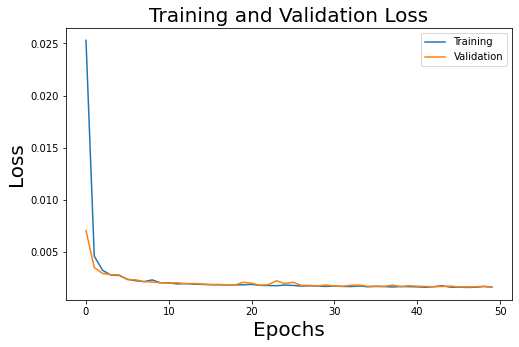

In [50]:
plotPerf(model) #plot accuracy and loss

In [51]:
foldPath = "M02_Denoised_test-x/"
if not os.path.exists(foldPath):
    os.makedirs(foldPath)
scan, DeNoisedScan = ModApp(autoencoder2, foldPath)

1/1 [==============================] - 0s 23ms/step


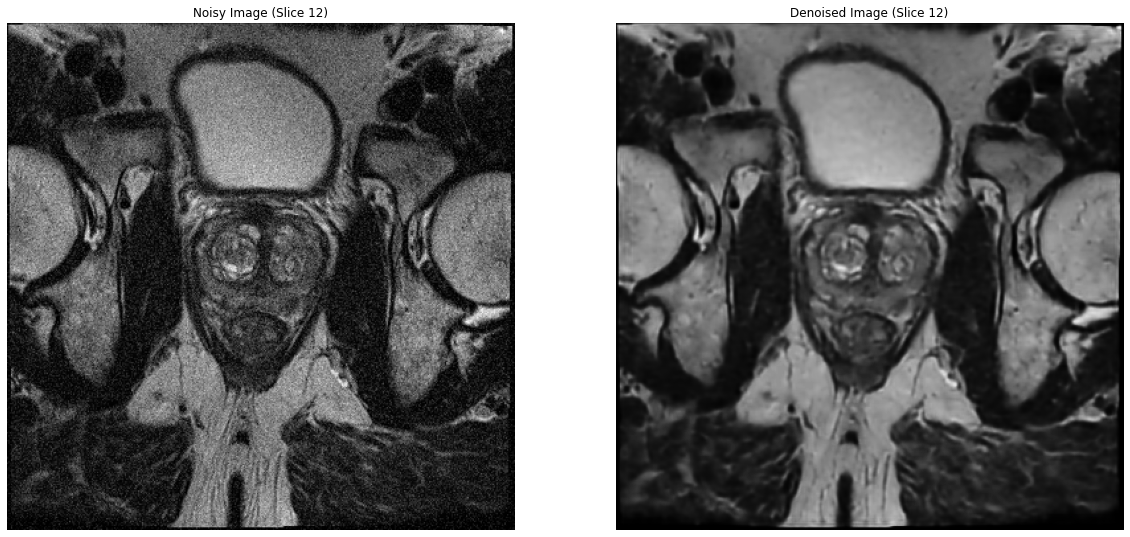

In [52]:
plotIMG(scan, DeNoisedScan.T, 11)

In [27]:
#!zip -r /content/M02_Denoised_test-x.zip /content/M02_Denoised_test-x

# MODEL 3:

Encoder:
* 3 convolutional layers
* 3 downsampling layers

Decoder:
* 3 deconvolutional layers
* 3 upsampling layers

In [69]:
#Define AutoEncoder 3

input_img = keras.Input(shape=(384,384,1)) #input layer stating image dimensions
#Encoder
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img) #use of 64 filters
x = layers.MaxPooling2D((2,2), padding='same')(x) #reduce spatial dimesions by 2 (384-->192)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x) #use of 64 filters
x = layers.MaxPooling2D((2,2), padding='same')(x) #reduce spatial dimesions by 2 (384-->192)
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x) #use of 64 filters

encoded = layers.MaxPooling2D((2,2), padding='same')(x) #reduce spatial dimensions by a factor of 2 (192-->96)
#Decoder
x = layers.Conv2DTranspose(128, (3,3), activation='relu', padding='same')(encoded) #use 64 filters
x = layers.UpSampling2D((2,2))(x) #increase spatial dimensions by factor of 2 (96-->192)
x = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same')(x) #use 64 filters
x = layers.UpSampling2D((2,2))(x) #increase spatial dimension by factor of 2 (192-->384)
x = layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x) #use 64 filters
x = layers.UpSampling2D((2,2))(x) #increase spatial dimension by factor of 2 (192-->384)

decoded = layers.Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same')(x) 

# #Implement our own loss function 
# #Define a RMSE loss function
# from keras import backend as K
# def root_mean_squared_error(y_true, y_pred):
#   return K.sqrt(K.mean(K.square(y_pred-y_true)))

#Model
autoencoder3 = keras.Model(input_img, decoded)
autoencoder3.compile(optimizer='adam', loss='mean_squared_error')
autoencoder3.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 384, 384, 1)]     0         
                                                                 
 conv2d_33 (Conv2D)          (None, 384, 384, 32)      320       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 192, 192, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 192, 192, 64)      18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 96, 96, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 96, 96, 128)       738

Epoch 1/50
39/39 [==============================] - 7s 156ms/step - loss: 0.0311 - val_loss: 0.0114
Epoch 2/50
39/39 [==============================] - 6s 148ms/step - loss: 0.0079 - val_loss: 0.0057
Epoch 3/50
39/39 [==============================] - 6s 146ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 4/50
39/39 [==============================] - 6s 148ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 5/50
39/39 [==============================] - 6s 147ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 6/50
39/39 [==============================] - 6s 146ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 7/50
39/39 [==============================] - 6s 148ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 8/50
39/39 [==============================] - 6s 146ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 9/50
39/39 [==============================] - 6s 148ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 10/50
39/39 [==============================] - 6s 148ms/step - loss: 0.0030 - val_loss: 0.0033

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

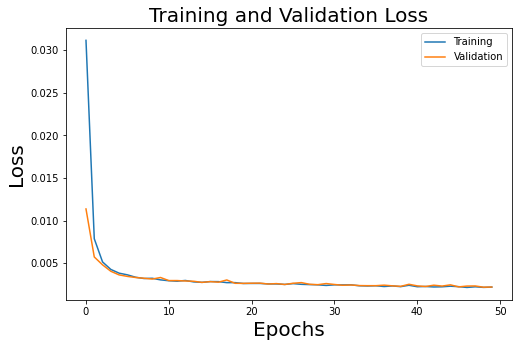

In [70]:
ep=50
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
model = autoencoder3.fit(train_iterator,
                        steps_per_epoch = ceil(trData.shape[0] / batchS), #2492 / 128 = 19.4
                        epochs=ep,
                        validation_data=val_iterator,
                        callbacks= [callback])

autoencoder3.save('model_03_Denoised.h5')
from google.colab import files
files.download('model_03_Denoised.h5')

plotPerf(model) #plot loss

1/1 [==============================] - 0s 25ms/step


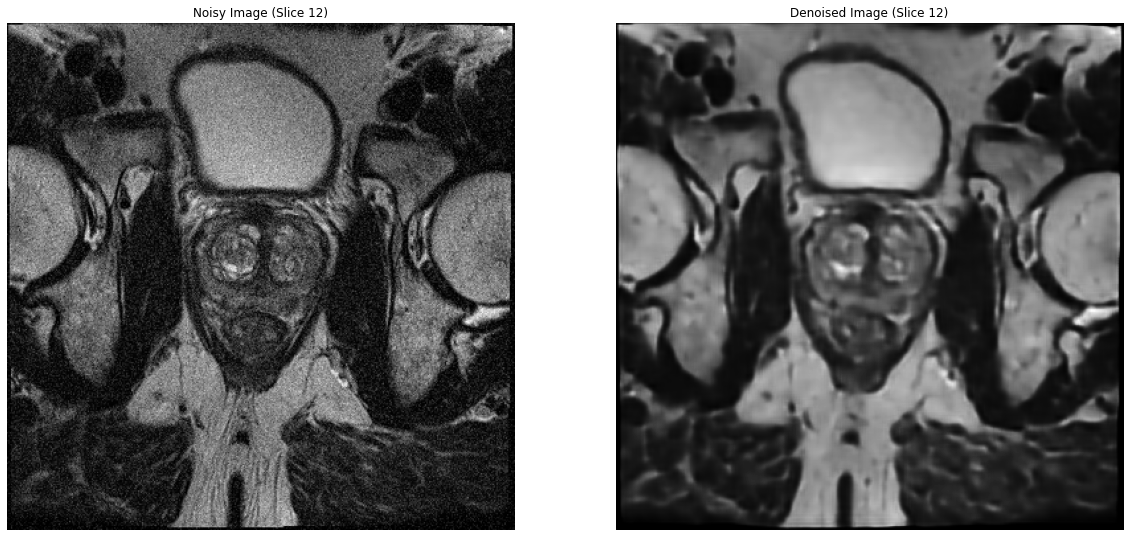

In [71]:
foldPath = "M03_Denoised_test-x/"
if not os.path.exists(foldPath):
    os.makedirs(foldPath)
scan, DeNoisedScan = ModApp(autoencoder3, foldPath)

plotIMG(scan, DeNoisedScan.T, 11)

# Results

Over all Model 1 and 2 performed similarly, reaching a val_loss of 0.0018 and 0.0016 respectively. Model 3 had the worse performance of the 3 models, reaching a vol_loss of 0.0022.

Model 2 was choosen as the best model.

# Saving denoised images

Run this code separately if the model is already provided.

In [ ]:
# #Data is in NIfTI format, so nibabel will be used to read the files
# import nibabel as nb
# import os
# import numpy as np
# from scipy.ndimage import zoom #function will be use to reshape image
# import tensorflow as tf
# from tensorflow import keras
# from keras import layers

# #Create an array with the name of files inside the folder
# def ReadFolder(path): #'path' defines the location of the folder
#     folder = os.listdir(path)
#   #Blank list 
#     data = []
#   #Loop to save 3D images in list
#     for i in folder:
#     #image is read
#         img = nb.load(path + i).get_fdata()
#         #print(img.shape)
#     #reshape to 384x384 in plane
#         img = zoom(img, (384/img.shape[0], 384/img.shape[1], 1))
#         img = img/img.max() #Normalization
#         img = np.transpose(img, (2,1,0))
#         #print(img.shape[-1])
#     #load each slice individualy to the list
#         for j in range(img.shape[0]):
#             data.append(img[j]) #try with img[].T
#     data = np.array(data, dtype='float16')
#     return data

# #Visualization of data
# import matplotlib.pyplot as plt
# def plotIMG(x, y):
#     fig, ax = plt.subplots(2,2)
#     fig.set_size_inches(10,10)
#     for j in range(2):
#         ax[0][j].imshow(x[j], cmap='gray')
#         ax[0][j].set_title('Train_x Image '+str(j+1))
#     for j in range(2):
#         ax[1][j].imshow(y[j], cmap='gray')
#         ax[1][j].set_title('Train_y Image '+str(j+1))
#     plt.show()
    
    
# #Function for fitting the model to the testing data and saving the new "Denoised" images in a folder
# def ModApp(autoencoder, SaveFolder):
#     for i in os.listdir('test-x/'): #The function loops through each scan
#         nft = nb.load('test-x/'+ i)
#         scan = nft.get_fdata()
#         #print(scan.shape)
#         scan = zoom(scan, (384/scan.shape[0], 384/scan.shape[1], 1)) #Reshape 384x384
#         scan = ( scan - scan.min() )/( scan.max() - scan.min() ) #Normalize
#         scan = np.transpose(scan, (2,1,0)) 
#         DeNoisedScan = autoencoder.predict(scan)
#           #print(DeNoisedScan[:,:,:,0].shape)
#         #DeNoisedScan = DeNoisedScan/DeNoisedScan.max()
#         #print(DeNoisedScan.shape)
#         DeNoisedScan = ( DeNoisedScan - DeNoisedScan.min() )/( DeNoisedScan.max() - DeNoisedScan.min() )
#         DeNoisedScan = np.transpose(DeNoisedScan[:,:,:,0])
#         final_img = nb.Nifti1Image(DeNoisedScan, nft.affine, nft.header)
#         nb.save(final_img, os.path.join(SaveFolder, i))
#     return scan, DeNoisedScan

# #Load model
# autoE = keras.models.load_model('model_02_Denoised.h5')

# #Apply model and save images in new folder
# foldPath = "M02_Denoised_test-x/"
# if not os.path.exists(foldPath):
#     os.makedirs(foldPath)
# scan, DeNoisedScan = ModApp(autoE, foldPath)

# #Plot new images
# plotIMG(scan, DeNoisedScan.T)